# Capstone Notebook

# Stakeholder and Business Problem

This project is intended to provide the Minnesota Department of Transportation (MNDOT) with information and recommendations about what factors lead to heavy traffic volume and if anything can be done along I-94 to mitigate these factors.

In [1]:
# Import tools and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
sns.set(font_scale = 1)

# try:
    # %load_ext autotime
# except:
    # !pip install ipython-autotime
    # %load_ext autotime
    
%load_ext autotime

time: 0 ns (started: 2023-04-03 08:59:46 -06:00)


In [2]:
# Read in traffic data
df = pd.read_csv('data\Metro_Interstate_Traffic_Volume.csv')

time: 78 ms (started: 2023-04-03 08:59:46 -06:00)


In [3]:
# Previewing data
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


time: 16 ms (started: 2023-04-03 08:59:46 -06:00)


In [4]:
# Renaming columns to show units of measuremen
df = df.rename(columns={'temp':'temp_k',
                        'rain_1h':'rain_mm',
                        'snow_1h':'snow_mm',
                        'clouds_all':'pct_cloud_cover'})

# Creating column with Fahrenheit values
df['temp_f'] = (df['temp_k'] - 273.15) * 9/5 + 32

time: 16 ms (started: 2023-04-03 08:59:46 -06:00)


In [5]:
df['date_time'] = pd.to_datetime(df['date_time'], infer_datetime_format=True)
df.set_index('date_time', inplace=True)

time: 46 ms (started: 2023-04-03 08:59:46 -06:00)


In [13]:
df['weather_main'].value_counts()

Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: weather_main, dtype: int64

time: 0 ns (started: 2023-04-03 09:40:38 -06:00)


In [6]:
df[df['temp_k'] == 0]

,holiday,temp_k,rain_mm,snow_mm,pct_cloud_cover,weather_main,weather_description,traffic_volume,temp_f
date_time,,,,,,,,,
2014-01-31 03:00:00,None,0.0,0.0,0.0,0,Clear,sky is clear,361,-459.67
2014-01-31 04:00:00,None,0.0,0.0,0.0,0,Clear,sky is clear,734,-459.67
2014-01-31 05:00:00,None,0.0,0.0,0.0,0,Clear,sky is clear,2557,-459.67
2014-01-31 06:00:00,None,0.0,0.0,0.0,0,Clear,sky is clear,5150,-459.67
2014-02-02 03:00:00,None,0.0,0.0,0.0,0,Clear,sky is clear,291,-459.67
2014-02-02 04:00:00,None,0.0,0.0,0.0,0,Clear,sky is clear,284,-459.67
2014-02-02 05:00:00,None,0.0,0.0,0.0,0,Clear,sky is clear,434,-459.67
2014-02-02 06:00:00,None,0.0,0.0,0.0,0,Clear,sky is clear,739,-459.67
2014-02-02 07:00:00,None,0.0,0.0,0.0,0,Clear,sky is clear,962,-459.67


time: 16 ms (started: 2023-04-03 08:59:46 -06:00)


In [7]:
df_daily = df.resample('D').mean()

time: 0 ns (started: 2023-04-03 08:59:46 -06:00)


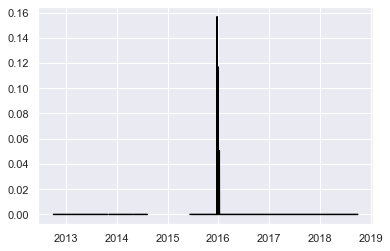

time: 266 ms (started: 2023-04-03 09:01:09 -06:00)


In [11]:
plt.plot(df_daily['snow_mm'], color = "black",label='Training Data')

In [9]:
df_daily

,temp_k,rain_mm,snow_mm,pct_cloud_cover,traffic_volume,temp_f
date_time,,,,,,
2012-10-02,290.403333,0.000000,0.0,29.133333,4219.266667,63.056000
2012-10-03,286.413500,0.000000,0.0,3.850000,3317.250000,55.874300
2012-10-04,289.357500,0.000000,0.0,16.708333,3747.458333,61.173500
2012-10-05,282.078182,0.000000,0.0,75.000000,4242.545455,48.070727
2012-10-06,277.746087,0.000000,0.0,61.652174,3256.956522,40.272957
...,...,...,...,...,...,...
2018-09-26,283.995833,0.010417,0.0,39.833333,3692.791667,51.522500
2018-09-27,286.268400,0.020000,0.0,61.200000,3777.360000,55.613120
2018-09-28,281.588333,0.000000,0.0,26.250000,3854.916667,47.189000


time: 31 ms (started: 2023-04-03 08:59:47 -06:00)
